In [ ]:
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import logging

# Налаштування логування
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_model_and_data():
    """Завантаження моделі та даних"""
    logger.info("2.1 Завантаження попередньо навченої моделі")
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    logger.info("2.2 Завантаження набору даних")
    train_dataset = load_dataset("imdb", split="train[:500]")
    eval_dataset = load_dataset("imdb", split="test[:100]")

    logger.info("2.3 Перевірка структури даних")
    logger.info(f"Розмір тренувального набору: {len(train_dataset)}")
    logger.info(f"Розмір тестового набору: {len(eval_dataset)}")

    return model, tokenizer, train_dataset, eval_dataset

def preprocess_data(dataset, tokenizer):
    """Попередня обробка даних"""
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=128
        )

    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    return tokenized_dataset

def train_model(model, tokenizer, train_dataset, eval_dataset):
    """Навчання моделі"""
    logger.info("4.1 Підготовка до навчання")

    # Токенізація даних
    train_tokenized = preprocess_data(train_dataset, tokenizer)
    eval_tokenized = preprocess_data(eval_dataset, tokenizer)

    # Налаштування параметрів навчання
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=50,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    # Ініціалізація тренера
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=eval_tokenized,
    )

    # Навчання моделі
    logger.info("4.2 Початок навчання")
    trainer.train()

    # Збереження моделі
    logger.info("4.3 Збереження моделі")
    trainer.save_model("./results")

    return trainer

def test_model(text, model, tokenizer):
    """Тестування моделі на новому тексті"""
    # Токенізація тексту
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

    # Отримання передбачення
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Визначення результату
    predicted_class = "позитивний" if probs[0][1] > probs[0][0] else "негативний"
    confidence = float(max(probs[0])) * 100

    return f"Текст: '{text}'\nНастрій: {predicted_class}\nВпевненість: {confidence:.2f}%"

def main():
    # Завантаження моделі та даних
    model, tokenizer, train_dataset, eval_dataset = load_model_and_data()

    # Навчання моделі
    trainer = train_model(model, tokenizer, train_dataset, eval_dataset)

    # Тестування на прикладах
    logger.info("\nТестування навченої моделі:")
    test_texts = [
        "This movie was fantastic! Great acting and amazing plot.",
        "Terrible waste of time and money. Don't watch it.",
        "It was okay, nothing special but not bad either.",
        "I really enjoyed the special effects and music!"
    ]

    model = AutoModelForSequenceClassification.from_pretrained("./results")
    for text in test_texts:
        print("\n" + test_model(text, model, tokenizer))

if __name__ == "__main__":
    main()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.114800,0.018526
2,0.001600,0.000835
3,0.000700,0.000569



Текст: 'This movie was fantastic! Great acting and amazing plot.'
Настрій: негативний
Впевненість: 99.92%

Текст: 'Terrible waste of time and money. Don't watch it.'
Настрій: негативний
Впевненість: 99.92%

Текст: 'It was okay, nothing special but not bad either.'
Настрій: негативний
Впевненість: 99.93%

Текст: 'I really enjoyed the special effects and music!'
Настрій: негативний
Впевненість: 99.90%


In [ ]:
# Завантажуємо збережену модель та токенізатор
model = AutoModelForSequenceClassification.from_pretrained("./results")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Ваш власний текст для аналізу (англійською)
my_text = "I think this movie has amazing special effects and great story!"

# Тестуємо
result = test_model(my_text, model, tokenizer)
print(result)

Текст: 'I think this movie has amazing special effects and great story!'
Настрій: негативний
Впевненість: 99.92%


In [ ]:
texts = [
    "The acting was terrible and the plot made no sense",
    "This is the best movie I have ever seen!",
    "The movie was just ok, nothing special"
]

for text in texts:
    result = test_model(text, model, tokenizer)
    print(result + "\n")

Текст: 'The acting was terrible and the plot made no sense'
Настрій: негативний
Впевненість: 99.91%

Текст: 'This is the best movie I have ever seen!'
Настрій: негативний
Впевненість: 99.90%

Текст: 'The movie was just ok, nothing special'
Настрій: негативний
Впевненість: 99.92%



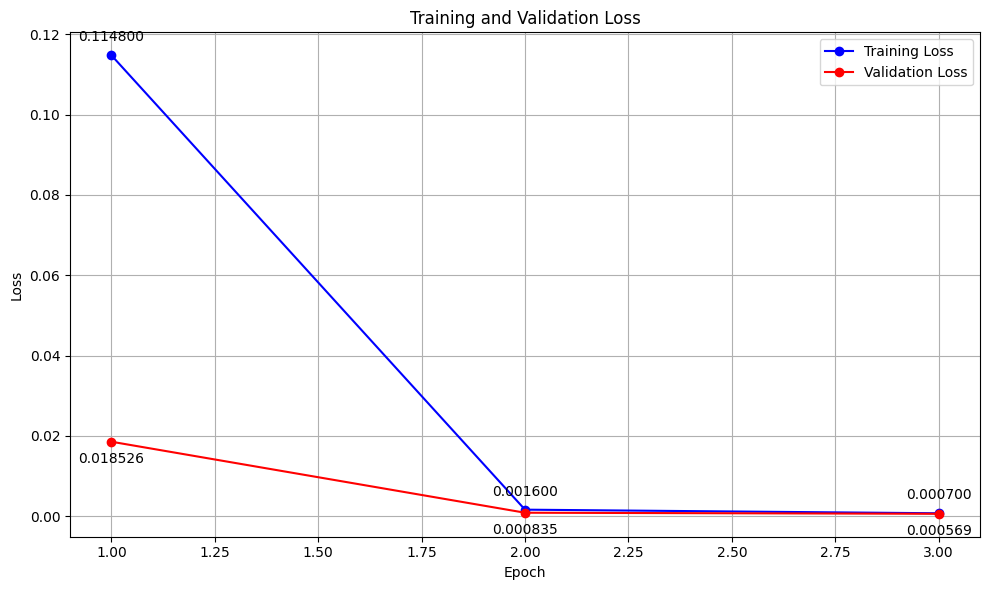

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Дані з тренування
epochs = np.array([1, 2, 3])
train_loss = np.array([0.114800, 0.001600, 0.000700])
val_loss = np.array([0.018526, 0.000835, 0.000569])

# Створюємо графік
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Додаємо точки даних
for i, (train, val) in enumerate(zip(train_loss, val_loss)):
    plt.annotate(f'{train:.6f}', (epochs[i], train), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{val:.6f}', (epochs[i], val), textcoords="offset points", xytext=(0,-15), ha='center')

plt.tight_layout()
plt.show()